# Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import acquire
import prepare

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Acquire


In [2]:
#acquire data and do rudimentary exploration
df = acquire.get_telco_data()
df.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [12]:
working = df.copy(deep=True)

# Prepare

### View data and verify suggested actions from acquire

In [4]:
# view dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
df.describe()
# id columns serve no purpose. *drop
# tenure appears to be in months, monthly charges in dollars
# where is total_charges? checked --> type == object. *must convert

,internet_service_type_id,payment_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.872923,2.315633,1.690473,0.162147,32.371149,64.761692
std,0.737796,1.148907,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,2.000000,3.000000,2.000000,0.000000,55.000000,89.850000
max,3.000000,4.000000,3.000000,1.000000,72.000000,118.750000


In [6]:
# convert series dtype to numeric after editing, and describe --> *make perm in prepare module
pd.to_numeric(df.total_charges.str.strip()).describe() 


count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

In [7]:
# dataframe containing categorical columns
cat_col = df.select_dtypes(exclude='number').drop(columns=['customer_id', 'total_charges'])

#iterate through categorical columns
for col in cat_col:
   print(df[col].value_counts())
   print(df[col].value_counts(normalize=True))
   print(('------\n'))


Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
------

No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
------

No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
------

Yes    6361
No      682
Name: phone_service, dtype: int64
Yes    0.903166
No     0.096834
Name: phone_service, dtype: float64
------

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: multiple_lines, dtype: float64
------

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: online_security, dty

In [8]:
def prep_telco(df):
    """
    purpose: accepts pandas dataframe and prepares it for 
    analysis according to spec
    
    ---
    returns: the prepared
    """
    df = df.drop(columns=['internet_service_type_id', 'payment_type_id', 'contract_type_id'])
    
    df['gender_encoded'] = df.gender.map({'Female':1, 'Male':0})
    df['partner_encoded'] = df.partner.map({'Yes':1, 'No':0})
    df['dependents_encoded'] = df.dependents.map({'Yes':1, 'No':0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes':1, 'No':0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes':1, 'No':0})
    df['churn_encoded'] = df.churn.map({'Yes':1, 'No':0})

    dummy_telco = pd.get_dummies(df[['contract_type',\
                                    'payment_type', \
                                    'internet_service_type', \
                                    'multiple_lines', \
                                    'online_security',\
                                    'online_backup',\
                                    'device_protection',\
                                    'tech_support',\
                                    'streaming_tv',\
                                    'streaming_movies']],\
                                 dummy_na=False, drop_first=True)
    
    
    df = pd.concat([df, dummy_telco], axis=1)
    df.total_charges = pd.to_numeric(df.total_charges.str.strip())
    
    return df

In [9]:
def final_prep(df):
    """
    purpose: final clean up of column names before feeding into models
    
    ---
    returns: the prepared
    """
    
    # drop columns that have been encoded/dummied
    df = df.drop(columns=['contract_type', 'payment_type', 'internet_service_type', 'multiple_lines', \
                        'online_security', 'online_backup', 'device_protection','tech_support',\
                        'streaming_tv','streaming_movies'])
                    
    # rename binary encoded columns
    df.rename(columns={'gender_encoded': 'gender', 'partner_encoded': 'partner', \
                    'dependents_encoded': 'dependents', 'phone_service_encoded': 'phone_service', \
                    'paperless_billing_encoded': 'paperless_billing', 'churn_encoded': 'churn'})

    return df

In [13]:
# reassign with prep_telco output to prepare for data split
working = prepare.prep_telco(working)
working

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,0,1,0,0,0,1,0,1,0,0
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,1,0,0,0,0,0,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,0,1,0,1,0,0,0,1,0,1
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,0,0,0,1,0,0,0,0
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,0,0,0,0,0,0,0,0,1
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,1,0,0,0,0,0,0,0,0
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,0,1,0,1,0,0,0,1


In [14]:
# split the data with target *churn*
train, validate, test = prepare.split_data(working, 'churn')

Prepared df: (7043, 47)

Train: (4225, 47)
Validate: (1409, 47)
Test: (1409, 47)


## **Prepare** Takeaways
Safe to get rid of columns used for SQL join.   
Customer id has no bearing on analysis  
Appears to have no missing values  
Numerous categorical columns need to be encoded  
`total_charges` not useful datatype
Broad View Stats as percentage of customer population
* Balanced (~50/50): gender, partner, multiple lines, streaming_tv, streaming_movies, 
* Imbalanced : multiple_lines, online_security, online_backup, dependents, device_protection, tech_support, paperless_billing, churn, contract_type, electronic_check, contract_type, internet_service_type

## Actions --> Executed in prepare.py module
** check** Encode Categorical Columns:
> `'gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security','online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'payment_type', 'internet_service_type'`

Drop: 
> `internet_service_type_id`, `payment_type_id`, `contract_type_id`, `customer_id` 
 
> `categorical columns after one-hot or binary encoding` --> save until after Explore

Convert: 
>`total_charges` -> `object` to `float64`</br> 

# Explore
> Univariate --> Bivariate --> Multivariate --> Statistical Tests

## Univariate
Create visuals for pertinent columns. 

In [16]:
# Create slice of dataframe columns for convenient visual exploration 
telco = train.columns[0:20]
telco

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'payment_type', 'internet_service_type'],
      dtype='object')

In [20]:
# Create dictionary for titles of visualizations. Backfill with takeaways
univariate_takeways = {'customer_id': 'Nothing pertinent observed',
 'gender': 'Roughly equal gender representation',
 'senior_citizen': 'Appears proportionally represented',
 'partner': 'Roughly equal representation between single and partnered customers',
 'dependents': 'Most customers without dependents',
 'tenure': 'Tenure is bookended by large numbers at the extremes',
 'phone_service': 'Most customers have phone service',
 'multiple_lines': 'Those with phone service are slightly more likely to NOT have multiple lines',
 'online_security': 'Most do not have online security',
 'online_backup': 'Most do not have online backup',
 'device_protection': 'Most do not have device protection',
 'tech_support': 'Most do not have tech support',
 'streaming_tv': 'Customers with internet are evenly split on streaming_tv',
 'streaming_movies': 'Customers with internet are evenly split on streaming_movies',
 'paperless_billing': 'Most customers opt for paperless billing',
 'monthly_charges': 'Large majority of customers pay above $60',
 'total_charges': 'Nothing interesting as total_charges likely to correlate with tenure',
 'churn': 'More have not churned than have',
 'contract_type': 'Month-to_month is the preferred contract type',
 'payment_type': 'Electronic Check most prefered payment type',
 'internet_service_type': 'Fiber Optic most popular internet service type'}

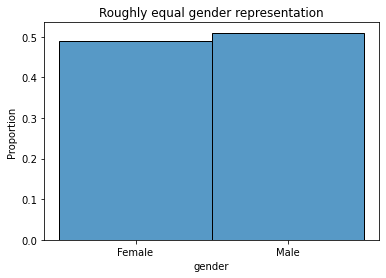

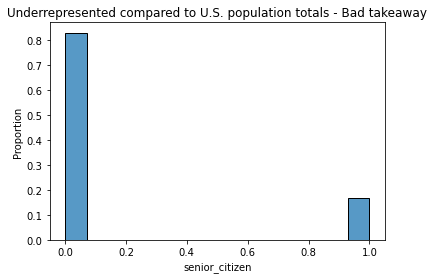

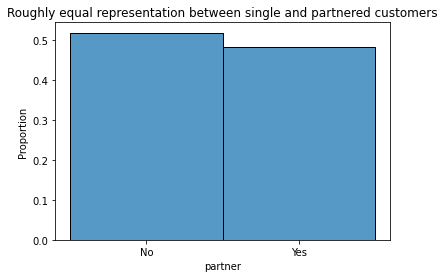

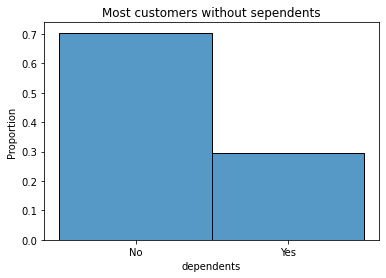

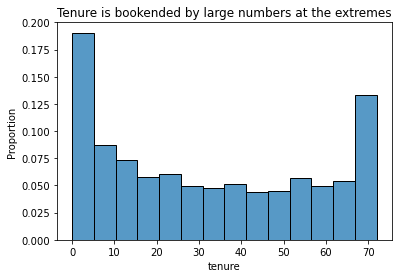

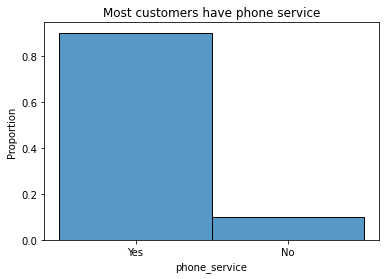

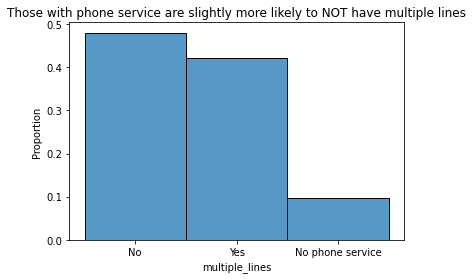

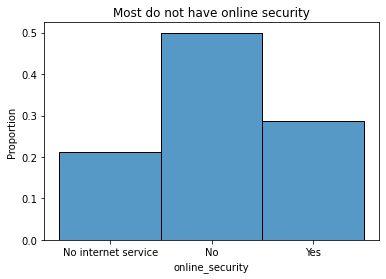

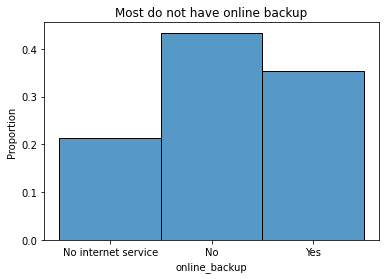

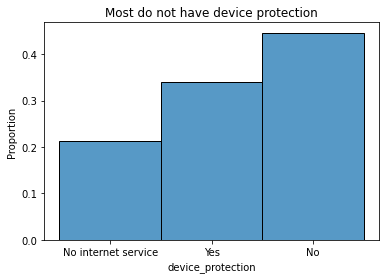

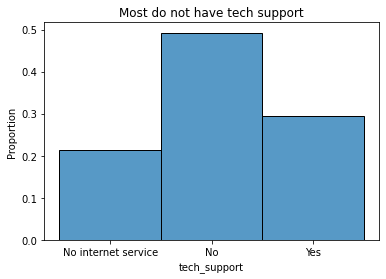

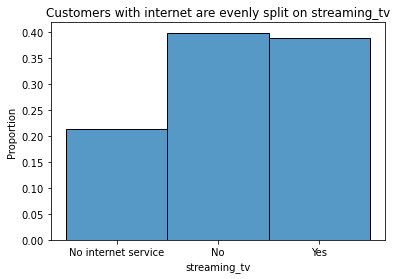

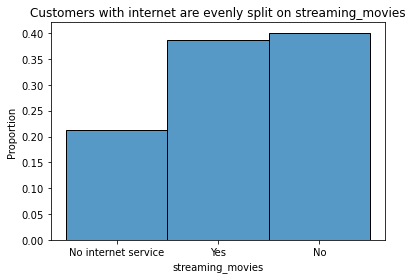

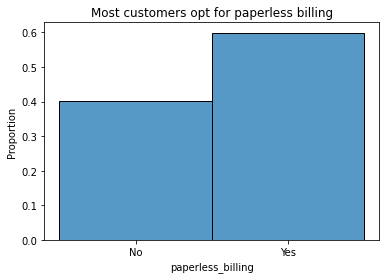

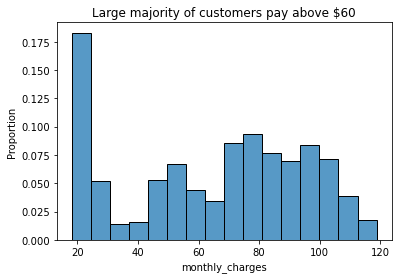

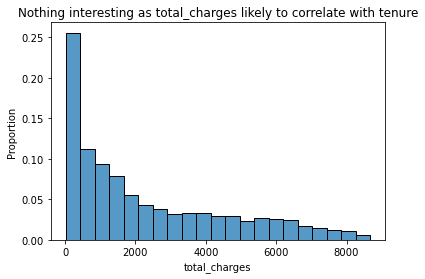

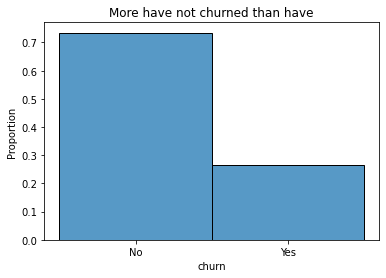

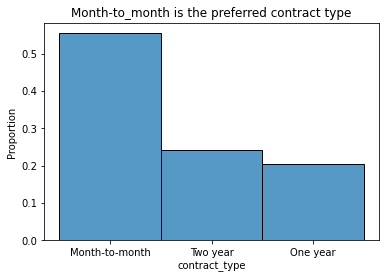

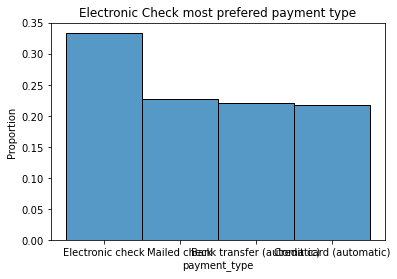

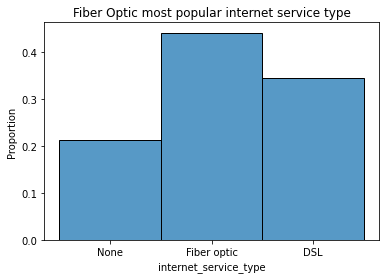

In [23]:
# loop through columns and display (with takeaway title) 
for col in telco:
    plt.title(univariate_takeways[col])
    sns.histplot(data=train, x=col, stat='proportion')
    plt.show()

### Univariate Takeaways
> Confirmed balanced split mentioned in **Prepare** for most columns

> Takeaways from *imbalanced* features:
* 'dependents': 'Most customers without dependents',  
* 'tenure': 'Tenure is bookended by large numbers at the extremes',
* 'phone_service': 'Most customers have phone service',
* 'multiple_lines': 'Those with phone service are slightly more likely to NOT have multiple lines',
* 'online_security': 'Most do not have online security',
* 'online_backup': 'Most do not have online backup',
* 'device_protection': 'Most do not have device protection',
* 'tech_support': 'Most do not have tech support',
* 'paperless_billing': 'Most customers opt for paperless billing',
* 'contract_type': 'Month-to_month is the preferred contract type',
* 'payment_type': 'Electronic Check most prefered payment type',
* 'internet_service_type': 'Fiber Optic most popular internet service type'


## Bivariate
Visuals exploring relationship between churn (target) and other features

In [31]:
#create title dictionary to later backfill
bivariate_takeaways = {'gender': 'Roughly equal gender representation in churn vs no_churn',
 'senior_citizen': 'Much less likely to churn than rest of population**',
 'partner': 'Single customers make up greater proportion of churned**',
 'dependents': 'Most customers without sependents',
 'tenure': 'Longer tenure seems associated with less churn**',
 'phone_service': 'Seems to have no change in churn vs no churn',
 'multiple_lines': 'Minimal change between churn/no_churn',
 'online_security': 'High level of churned had no online security',
 'online_backup': 'High level of churned had no online backup',
 'device_protection': 'High level of churned had no device_protection',
 'tech_support': 'High level of churned had no online security',
 'streaming_tv': 'Slightly higher percentage of churned had no streaming tv. A reversal from no churn',
 'streaming_movies': 'Roughly equal proportions of streaming optinos churned/no churn',
 'paperless_billing': 'Opting for paperless billing makes up greater portion of churned',
 'monthly_charges': 'Churned customers have higher than average bills**',
 'total_charges': 'Nothing interesting',
 'churn': '-----------',
 'contract_type': 'Month-to_month make up much greater proportion of churned**',
 'payment_type': 'Electronic check more highly represented among churned vs no churn',
 'internet_service_type': 'Fiber Optic overrepresented among the churned**'}

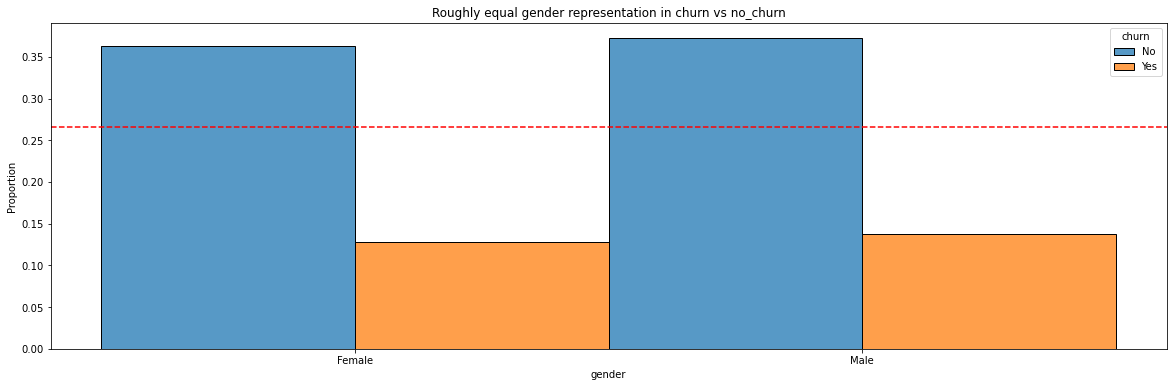

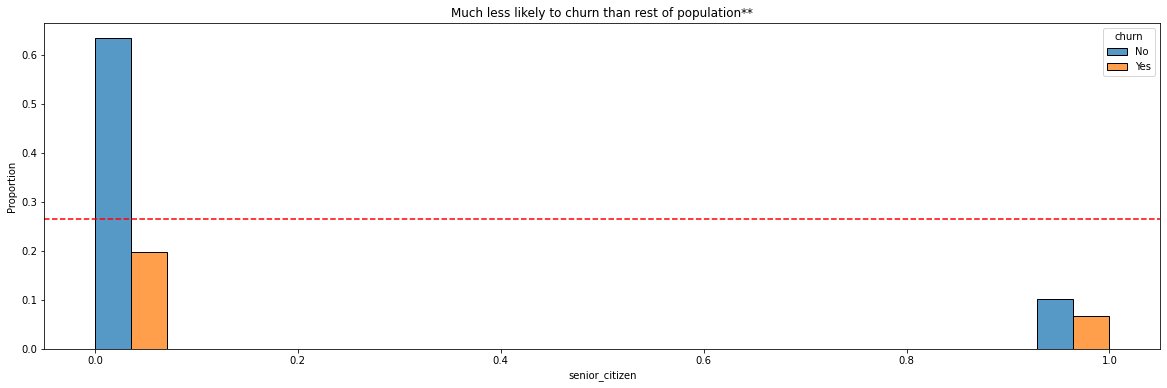

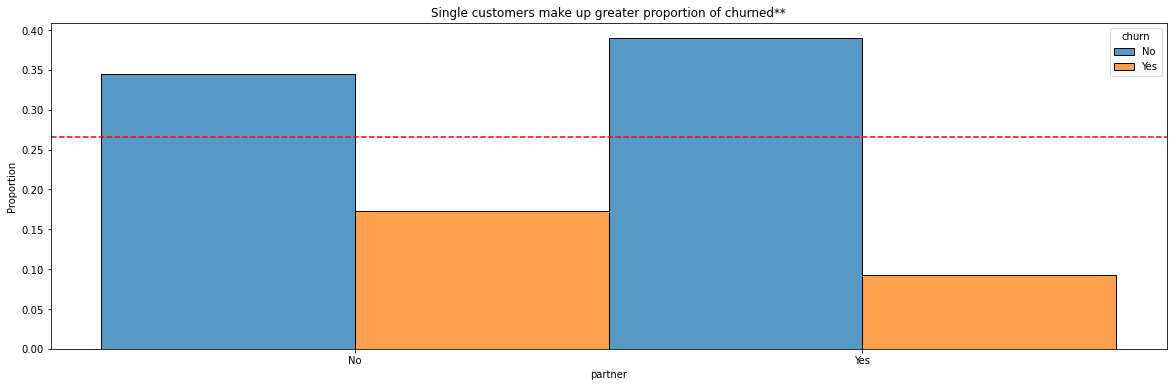

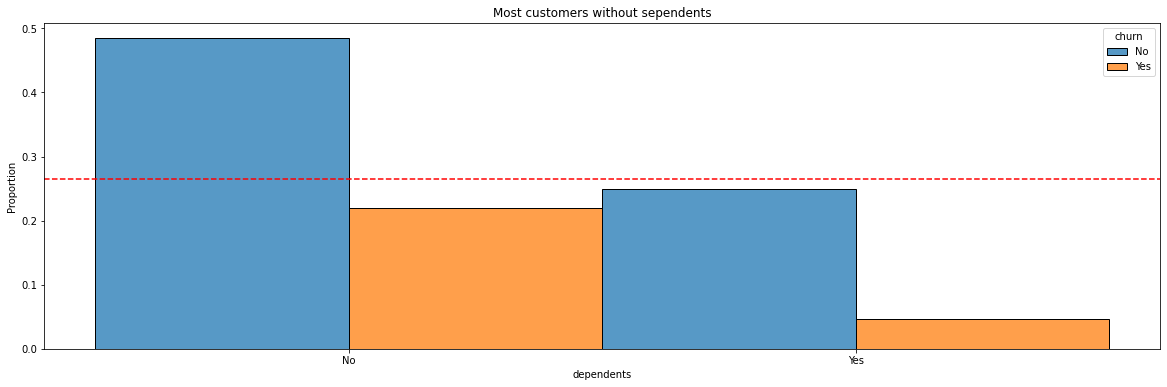

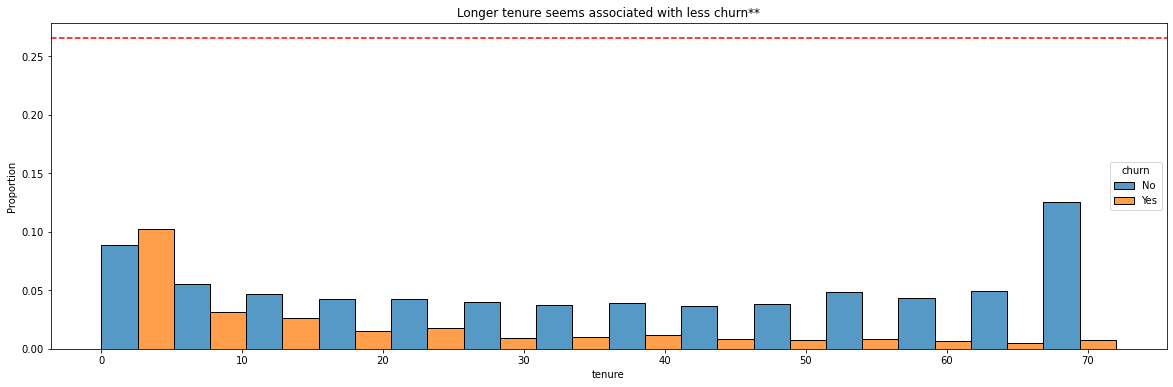

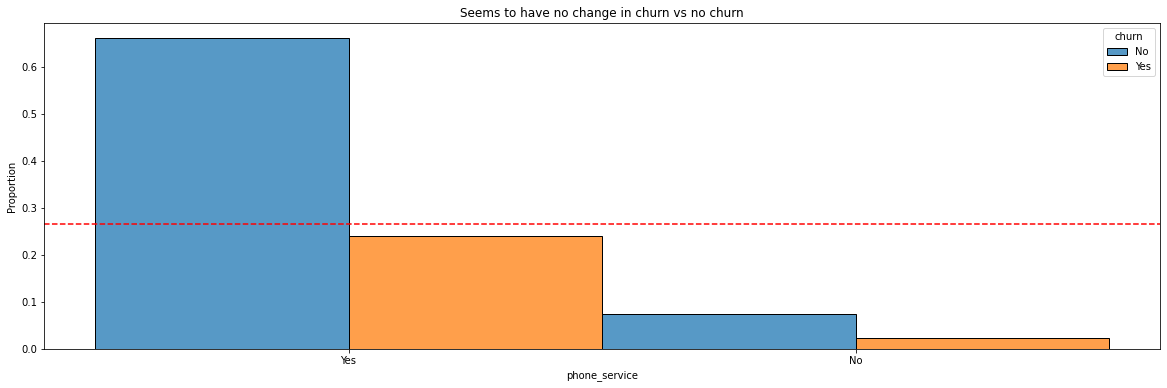

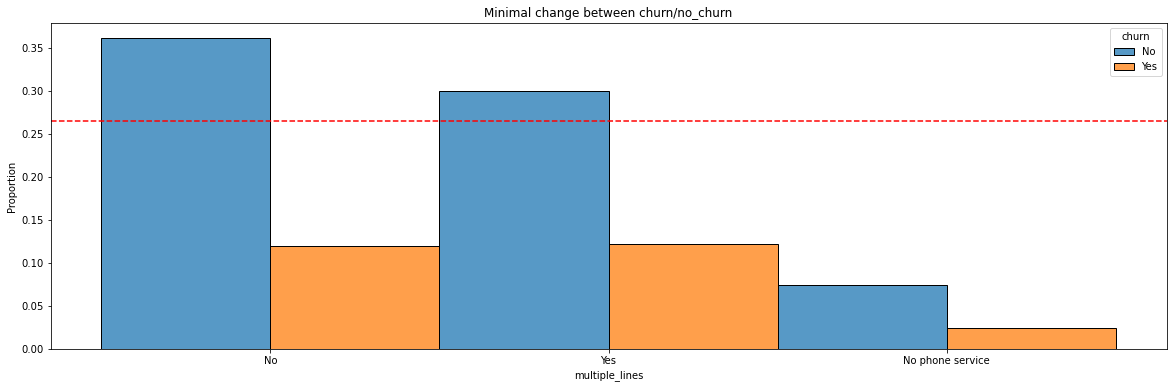

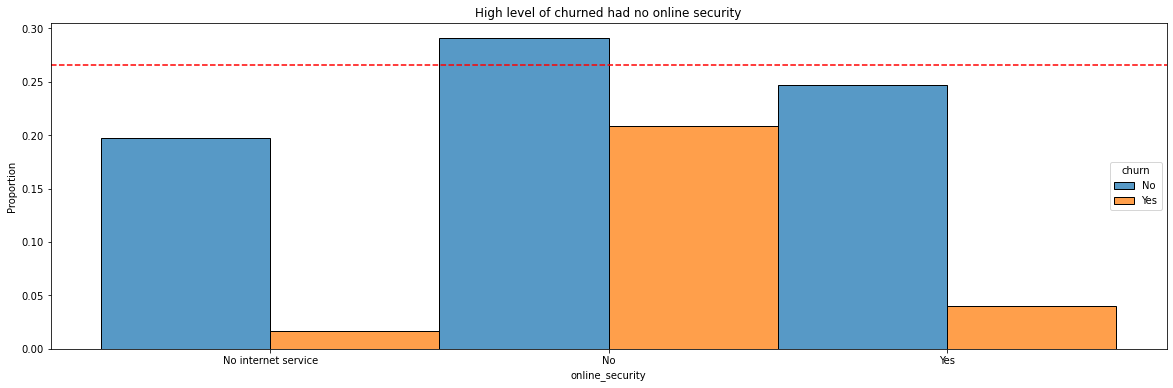

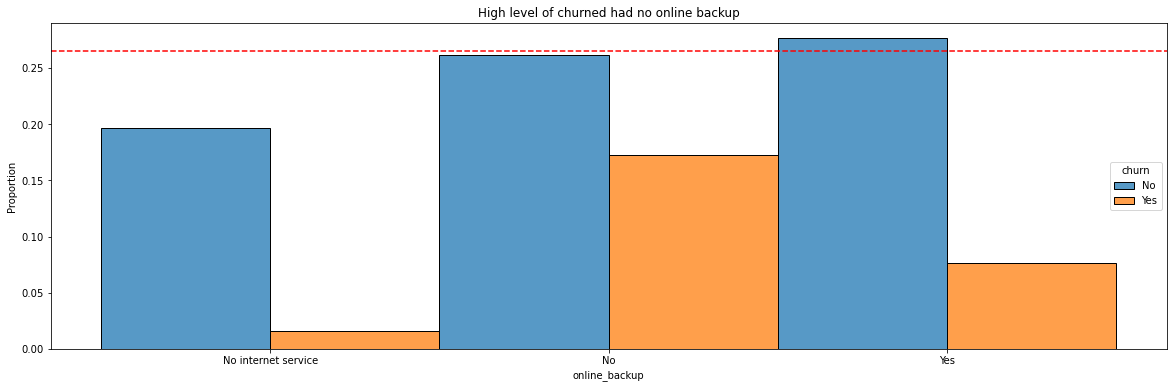

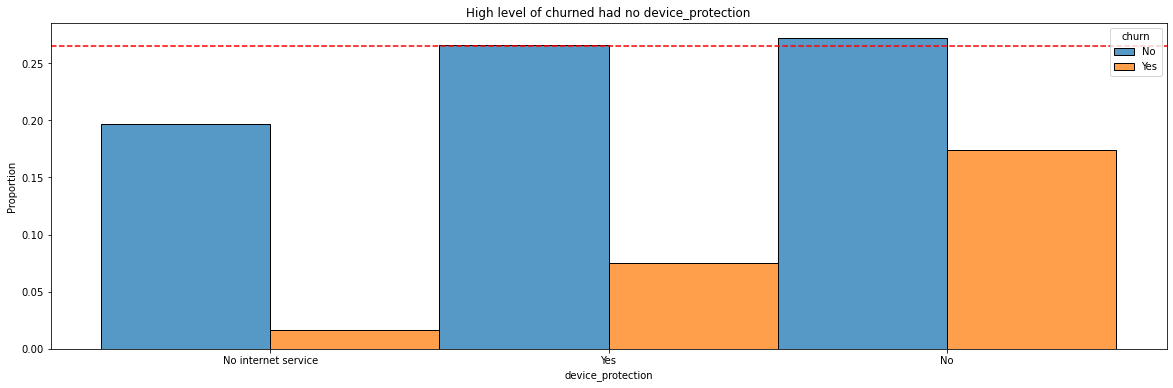

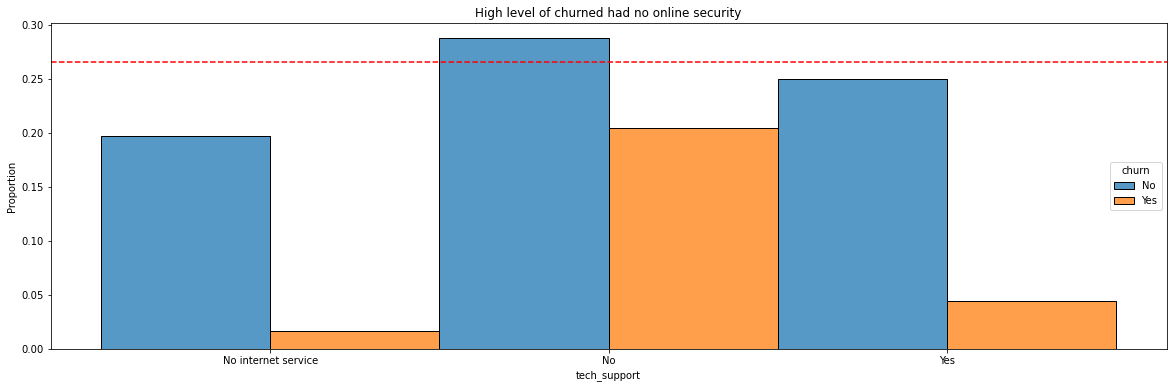

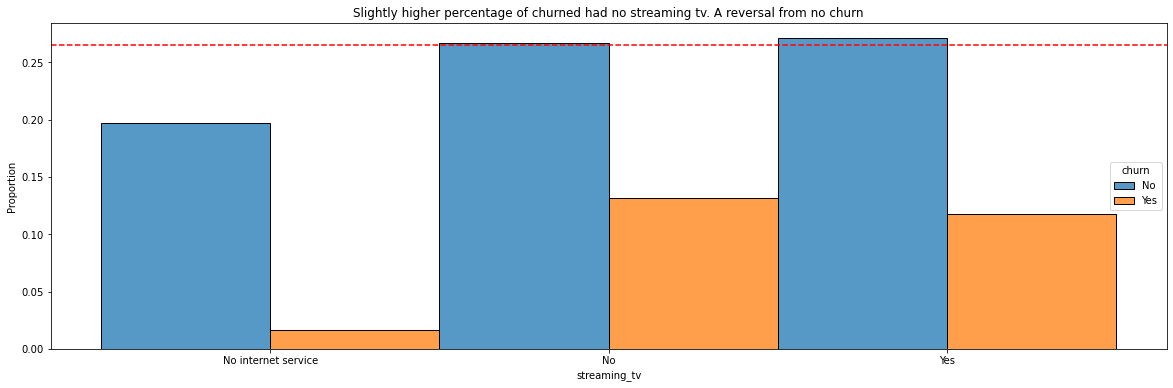

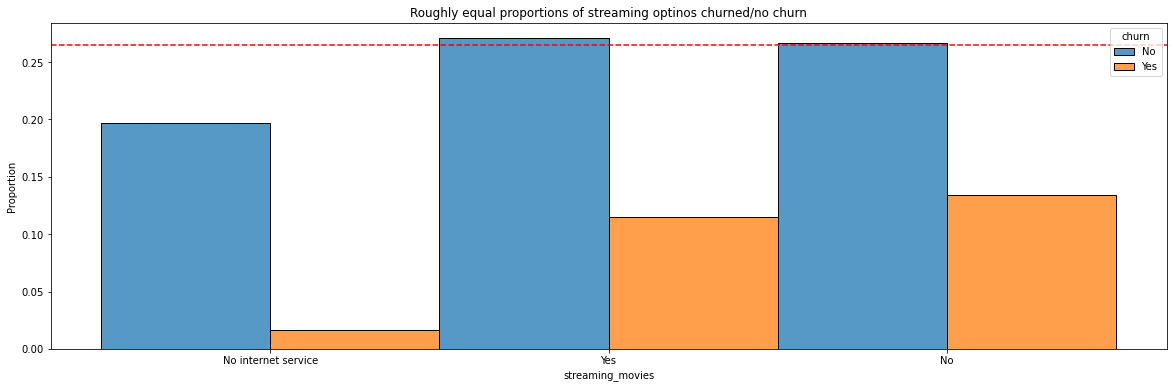

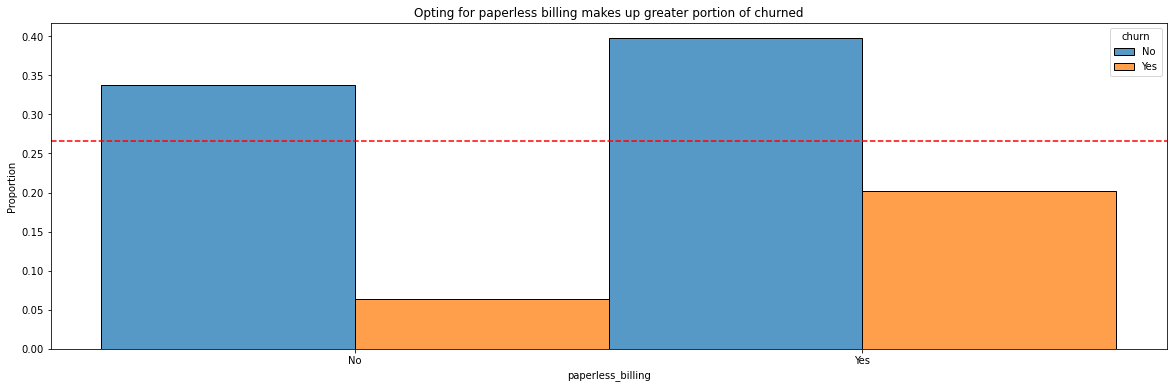

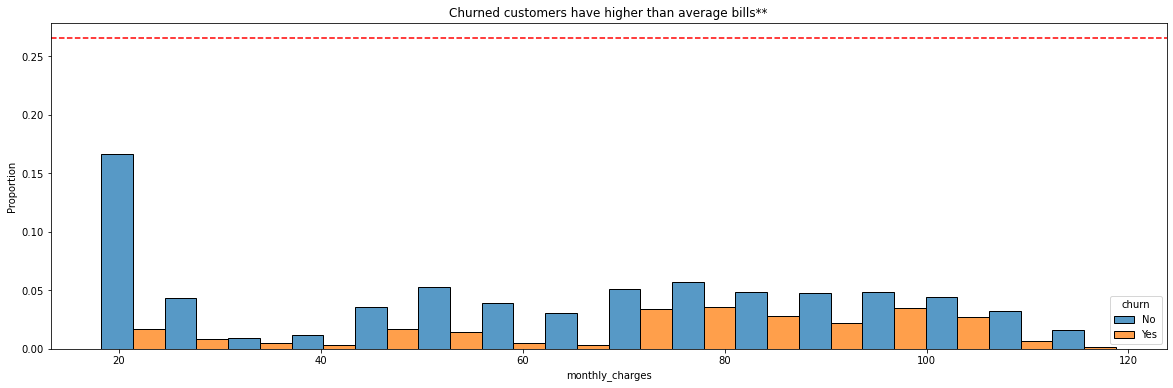

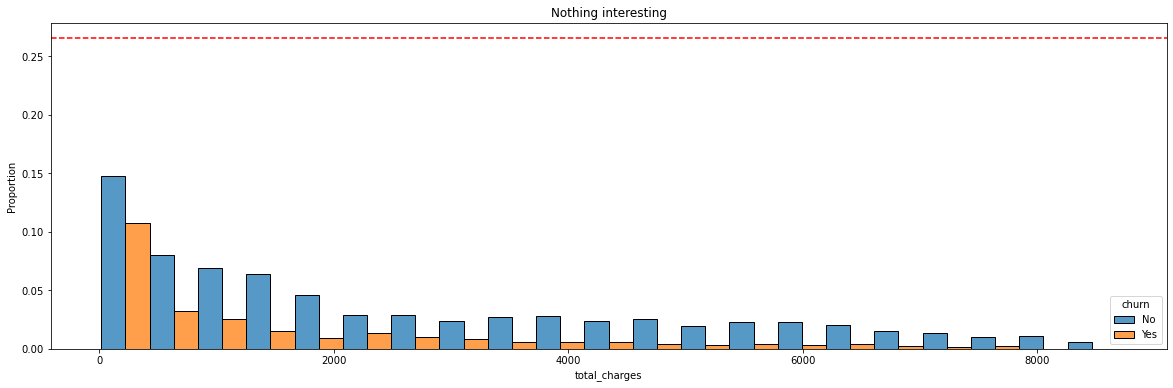

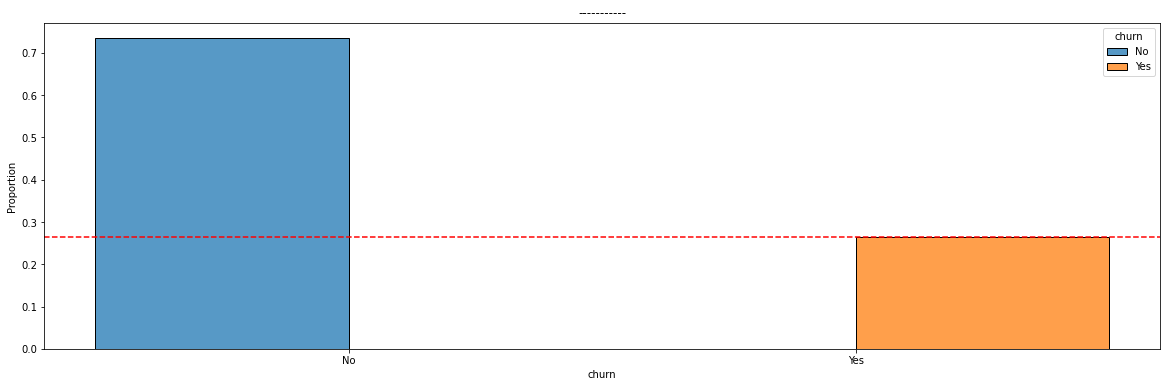

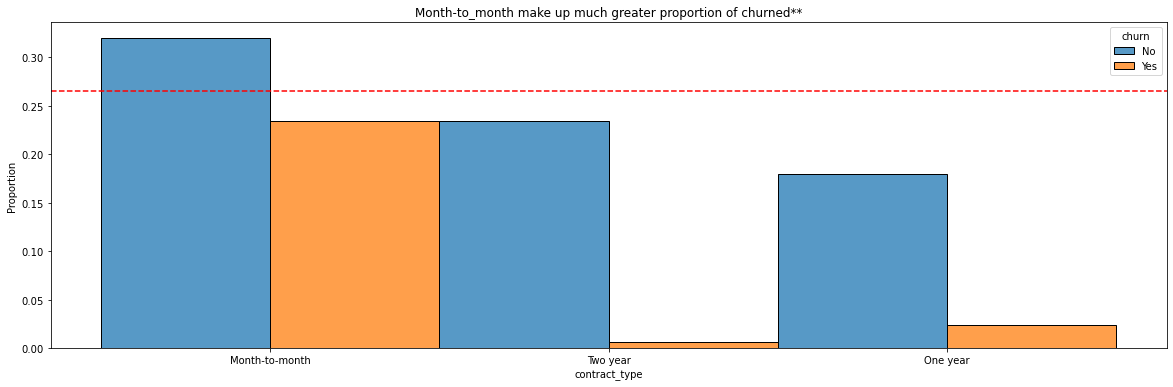

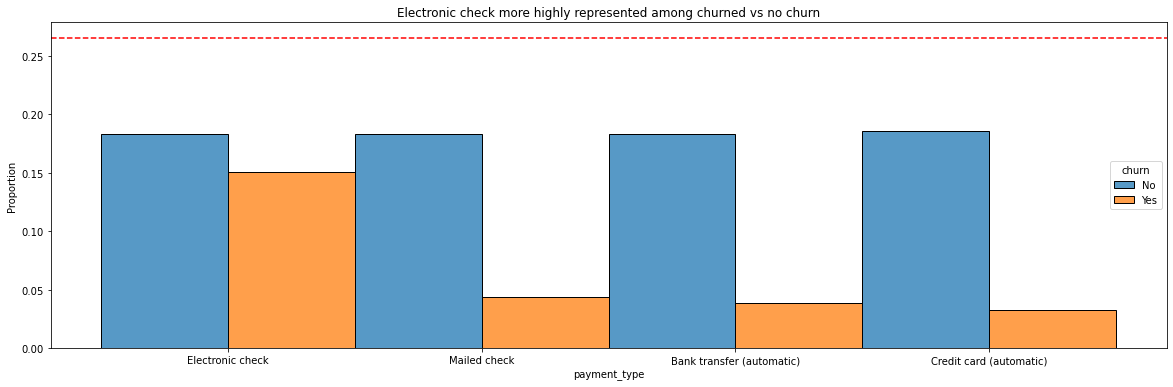

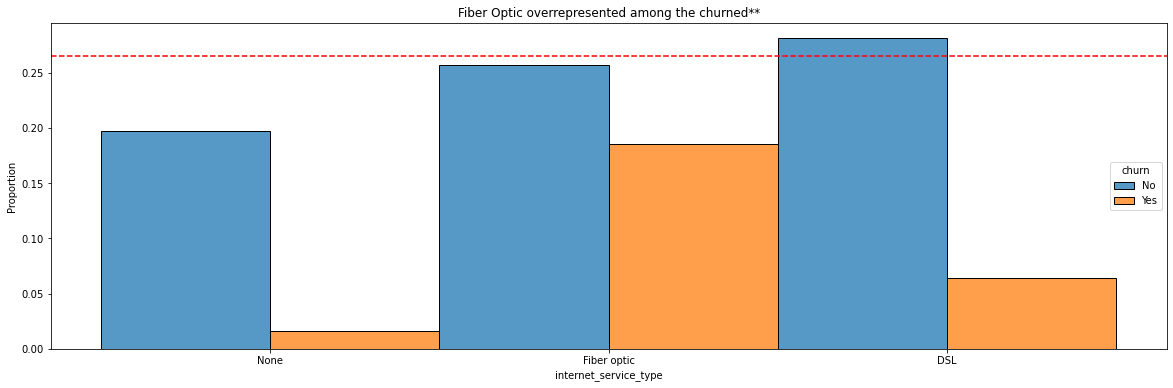

In [32]:
for col in telco:
    plt.figure(figsize=(20,6))
    sns.histplot(data=train, x=col, hue='churn', multiple='dodge', stat='proportion')
    plt.axhline(y=train.churn_encoded.mean(), color='red', linestyle='dashed', label='Population Churn Rate')
    plt.title(bivariate_takeaways[col])
    plt.show()

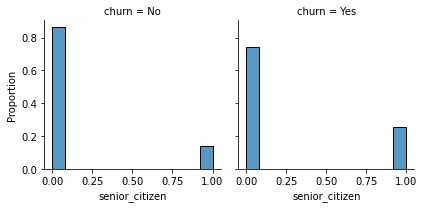

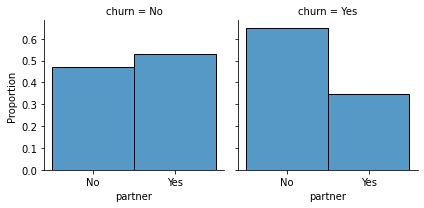

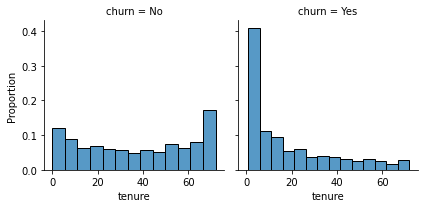

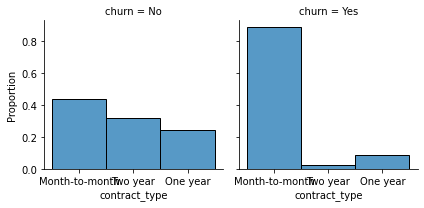

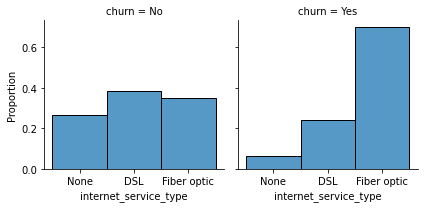

In [37]:
# create different visuals for columns identified above for further exploration or improved clarity
bivariate_b = ['senior_citizen', 'partner', 'tenure', 'contract_type', 'internet_service_type']
for col in bivariate_b:
    viz_biv = sns.FacetGrid(data=train, col='churn')
    viz_biv.map_dataframe(sns.histplot, x=col, stat="proportion", multiple='dodge')
    #viz_bivo.fig.suptitle(bivariate_b[col], y=1.05)